In [1]:
import sys
!pip3 install matplotlib
!pip3 install pandas
!pip3 install seaborn
!pip3 install --upgrade tensorflow-gpu
!pip3 install import-ipynb
!pip3 install cuda-python
!pip3 install -U scikit-learn
!pip3 install bayesian-optimization

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import glob
import math
import pickle
import time

import import_ipynb
import AttackClassificationModel

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.optimizers.legacy import Nadam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from bayes_opt import BayesianOptimization

%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


importing Jupyter notebook from AttackClassificationModel.ipynb
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))

# Data Pre-Processing

In [3]:
df_traffic = AttackClassificationModel.get_files("../../botiot")

# Get DDoS
df_ddos, label_ddos = AttackClassificationModel.get_attack(0, df_traffic)

# Get DoS
df_dos, label_dos = AttackClassificationModel.get_attack(1, df_traffic)

# Get Reconaissance
df_rec, label_rec = AttackClassificationModel.get_attack(2, df_traffic)

# Get Theft
df_theft, label_theft = AttackClassificationModel.get_attack(3, df_traffic)
#df_theft = np.concatenate([df_theft, df_theft, df_theft, df_theft, df_theft, df_theft, df_theft,
#                           df_theft, df_theft, df_theft, df_theft, df_theft, df_theft, df_theft])
#label_theft = np.concatenate([label_theft, label_theft, label_theft, label_theft, label_theft, label_theft, label_theft,
#                              label_theft, label_theft, label_theft, label_theft, label_theft, label_theft, label_theft])

In [4]:
# Normalize with the min-max scaler
scaler = MinMaxScaler()
df_ddos_norm = scaler.fit_transform(df_ddos)
df_dos_norm = scaler.fit_transform(df_dos)
df_rec_norm = scaler.fit_transform(df_rec)
df_theft_norm = scaler.fit_transform(df_theft)

# Sets

In [5]:
# Train
len_ddos_train = int(0.7 * len(df_ddos_norm))
X_ddos_train = df_ddos_norm[:len_ddos_train]

len_dos_train = int(0.7 * len(df_dos_norm))
X_dos_train = df_dos_norm[:len_dos_train]

len_rec_train = int(0.7 * len(df_rec_norm))
X_rec_train = df_rec_norm[:len_rec_train]

len_theft_train = int(0.7 * len(df_theft_norm))
X_theft_train = df_theft_norm[:len_theft_train]

X_train = np.concatenate([X_ddos_train, X_dos_train, X_rec_train, X_theft_train])
Y_train = np.concatenate([label_ddos[:len_ddos_train], label_dos[:len_dos_train], label_rec[:len_rec_train], label_theft[:len_theft_train]])

/tmp/ipykernel_15969/4009843007.py:15: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Y_train = np.concatenate([label_ddos[:len_ddos_train], label_dos[:len_dos_train], label_rec[:len_rec_train], label_theft[:len_theft_train]])


In [6]:
# Test
len_ddos_test = len_ddos_train + int(0.15 * len(df_ddos_norm))
X_ddos_test = df_ddos_norm[len_ddos_train : len_ddos_test]

len_dos_test = len_ddos_train + int(0.15 * len(df_dos_norm))
X_dos_test = df_dos_norm[len_dos_train : len_dos_test]

len_rec_test = len_rec_train + int(0.15 * len(df_rec_norm))
X_rec_test = df_rec_norm[len_rec_train : len_rec_test]

len_theft_test = len_theft_train + int(0.15 * len(df_theft_norm))
X_theft_test = df_theft_norm[len_theft_train : len_theft_test]

X_test = np.concatenate([X_ddos_test, X_dos_test, X_rec_test, X_theft_test])
Y_test = np.concatenate([label_ddos[len_ddos_train : len_ddos_test], label_dos[len_dos_train : len_dos_test], label_rec[len_rec_train : len_rec_test], label_theft[len_theft_train : len_theft_test]])

/tmp/ipykernel_15969/623701611.py:15: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Y_test = np.concatenate([label_ddos[len_ddos_train : len_ddos_test], label_dos[len_dos_train : len_dos_test], label_rec[len_rec_train : len_rec_test], label_theft[len_theft_train : len_theft_test]])


In [7]:
# Validation
X_ddos_val = df_ddos_norm[len_ddos_test:]
X_dos_val = df_dos_norm[len_dos_test:]
X_rec_val = df_rec_norm[len_rec_test:]
X_theft_val = df_theft_norm[len_theft_test:]

X_val = np.concatenate([X_ddos_val, X_dos_val, X_rec_val, X_theft_val])
Y_val = np.concatenate([label_ddos[len_ddos_test:], label_dos[len_dos_test:], label_rec[len_rec_test:], label_theft[len_theft_test:]])

/tmp/ipykernel_15969/1841741387.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Y_val = np.concatenate([label_ddos[len_ddos_test:], label_dos[len_dos_test:], label_rec[len_rec_test:], label_theft[len_theft_test:]])


In [8]:
X_train_CNN = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_CNN = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_val_CNN = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

samples, feature, depth = X_train_CNN.shape

# Model

In [9]:
# Initial values
batch_size = 50
number_features = 35
learning_rate = 0.008
epochs = 5

# Dictionary
dict_params = { 'learning_rate': learning_rate, 'batch_size': round(batch_size), 'epochs': round(epochs) }
pbounds = { 'learning_rate': (0.000001, 0.001), 'batch_size': (10, 30), 'epochs': (1, 50) }

In [10]:
cnn_model = AttackClassificationModel.CNN(feature, depth, 4)
reduce_lr = ReduceLROnPlateau(moniter = 'val_loss', factor = 0.1, patience = 10)

# Hyperparameter Optimization

In [11]:
def maximize_training(X_train = X_train_CNN,
                      Y_train = Y_train, 
                      X_val = X_val_CNN, 
                      Y_val = Y_val, 
                      X_test = X_test_CNN, 
                      Y_test = Y_test, 
                      learning_rate = learning_rate, 
                      epochs = epochs, 
                      batch_size = batch_size,
                      reduce_lr = reduce_lr):
    
    nadam = Nadam(learning_rate = dict_params['learning_rate'], beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, schedule_decay = 0.004)
    model = AttackClassificationModel.CNN(feature, depth, 4)
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam", metrics = ["accuracy"])
    
    history = model.fit(X_train, Y_train, 
                        epochs = dict_params['epochs'], 
                        batch_size = dict_params['batch_size'], 
                        validation_data = (X_val, Y_val),
                        callbacks = [reduce_lr],
                        verbose = 0)

    scores = model.evaluate(X_test, Y_test)
    return scores[1]

In [12]:
'''
# Apply Bayesian optimization to choose the best hyperparameters

opt = BayesianOptimization(f = maximize_training,
                           pbounds = pbounds,
                           verbose = 2, 
                           random_state = 1)

opt_start = time.time()

opt.maximize(init_points = 5, n_iter = 5)

opt_end = time.time()
opt_time = opt_end - opt_start
print("Optimization time:", opt_time)

learning_rate = opt.max['params']['learning_rate']
epochs = round(opt.max['params']['epochs'])
batch_size = round(opt.max['params']['batch_size'])
'''

'\n# Apply Bayesian optimization to choose the best hyperparameters\n\nopt = BayesianOptimization(f = maximize_training,\n                           pbounds = pbounds,\n                           verbose = 2, \n                           random_state = 1)\n\nopt_start = time.time()\n\nopt.maximize(init_points = 5, n_iter = 5)\n\nopt_end = time.time()\nopt_time = opt_end - opt_start\nprint("Optimization time:", opt_time)\n\nlearning_rate = opt.max[\'params\'][\'learning_rate\']\nepochs = round(opt.max[\'params\'][\'epochs\'])\nbatch_size = round(opt.max[\'params\'][\'batch_size\'])\n'

# Classify Attacks

In [13]:
# Training step with the best hyperparameters
learning_rate = 0.0009473561476260903
epochs = 9
batch_size = 19
opt_time = 10794.952757835388

In [14]:
nadam = Nadam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, schedule_decay = 0.004)
cnn_model.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam", metrics = ["accuracy"])

for i in range(1):
    print("Iteration " + str(i))
    
    # Train
    cnn_model, train_time = AttackClassificationModel.train(X_train_CNN, Y_train, X_val_CNN, Y_val, epochs, batch_size, reduce_lr, cnn_model)
    
    # Test
    Y_pred, test_time = AttackClassificationModel.test(X_test_CNN, cnn_model)
    
    # Multi classification metrics
    labels = ['DDoS', 'DoS', 'Reconaissance', 'Theft']
    acc, f1, pre, rec = AttackClassificationModel.get_scores(Y_test, Y_pred, labels)
    
    # Print results
    AttackClassificationModel.print_results(learning_rate,
                                            epochs,
                                            batch_size,
                                            X_train,
                                            X_val,
                                            X_test,
                                            opt_time,
                                            train_time,
                                            test_time,
                                            acc,
                                            f1,
                                            pre,
                                            rec,
                                            Y_test,
                                            Y_pred,
                                            "CNN",
                                            "Results/botiot.txt")
    
    print("")

Iteration 0
Train on 2567630 samples, validate on 356756 samples
Epoch 1/9
2567603/2567630 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 0.9998

/home/andressa.amaral/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


2567630/2567630 [==============================] - 728s 283us/sample - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0019 - val_accuracy: 0.9998 - lr: 0.0010
Epoch 2/9
2567630/2567630 [==============================] - 723s 282us/sample - loss: 4.4463e-04 - accuracy: 1.0000 - val_loss: 2.0594e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/9
2567630/2567630 [==============================] - 722s 281us/sample - loss: 3.2883e-04 - accuracy: 1.0000 - val_loss: 8.9627e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/9
2567630/2567630 [==============================] - 724s 282us/sample - loss: 4.0278e-04 - accuracy: 1.0000 - val_loss: 1.1935e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/9
2567630/2567630 [==============================] - 721s 281us/sample - loss: 2.9998e-04 - accuracy: 1.0000 - val_loss: 9.4550e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/9
2567630/2567630 [==============================] - 721s 281us/sample - loss: 4.2474e-04 - accuracy: 1.0000 - val_loss: 4.4927e-0

/home/andressa.amaral/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Testing time: 48.919934034347534



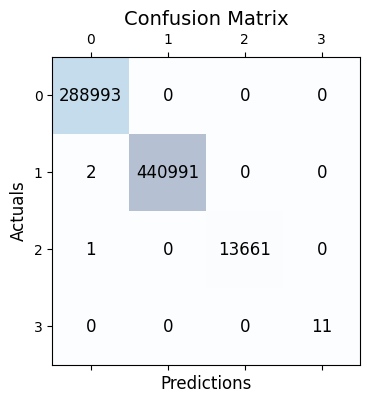

In [15]:
conf_matrix = confusion_matrix(Y_test, Y_pred)

fig, ax = plt.subplots(figsize = (4, 4))
ax.matshow(conf_matrix, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x = j, y = i,s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'large')
 
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.savefig("Results/Confusion Matrix/Botiot CNN")
plt.show()

# NB Model

In [16]:
# Model
nb_model = GaussianNB()

for i in range(1):
    print("Iteration " + str(i))
    
    # Train
    nb_model, train_time = AttackClassificationModel.train_nb_knn(X_train, Y_train, nb_model)
    
    # Test
    Y_pred, test_time = AttackClassificationModel.test_nb_knn(X_test, nb_model)
    
    # Multi classification metrics
    labels = ['DDoS', 'DoS', 'Reconaissance', 'Theft']
    acc, f1, pre, rec = AttackClassificationModel.get_scores(Y_test, Y_pred, labels)
    
    # Print results
    AttackClassificationModel.print_results(learning_rate,
                                            epochs,
                                            batch_size,
                                            X_train,
                                            X_val,
                                            X_test,
                                            opt_time,
                                            train_time,
                                            test_time,
                                            acc,
                                            f1,
                                            pre,
                                            rec,
                                            Y_test,
                                            Y_pred,
                                            "NB",
                                            "Results/botiot.txt")
    
    print("")

Iteration 0
Testing time: 0.600801944732666



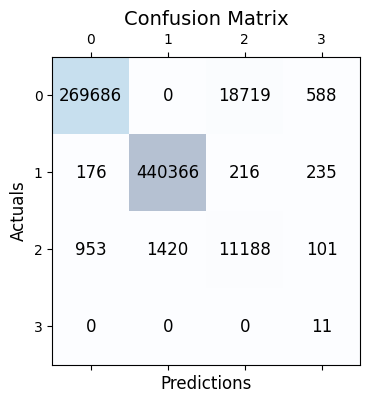

In [17]:
conf_matrix = confusion_matrix(Y_test, Y_pred)

fig, ax = plt.subplots(figsize = (4, 4))
ax.matshow(conf_matrix, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x = j, y = i,s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'large')
 
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.savefig("Results/Confusion Matrix/Botiot NB")
plt.show()

# KNN Model

In [18]:
# Model
knn_model = KNeighborsClassifier(n_neighbors = 50)

for i in range(1):
    print("Iteration " + str(i))
    
    # Train
    knn_model, train_time = AttackClassificationModel.train_nb_knn(X_train, Y_train, knn_model)
    
    # Test
    Y_pred, test_time = AttackClassificationModel.test_nb_knn(X_test, knn_model)
    
    # Multi classification metrics
    labels = ['DDoS', 'DoS', 'Reconaissance', 'Theft']
    acc, f1, pre, rec = AttackClassificationModel.get_scores(Y_test, Y_pred, labels)
    
    # Print results
    AttackClassificationModel.print_results(learning_rate,
                                            epochs,
                                            batch_size,
                                            X_train,
                                            X_val,
                                            X_test,
                                            opt_time,
                                            train_time,
                                            test_time,
                                            acc,
                                            f1,
                                            pre,
                                            rec,
                                            Y_test,
                                            Y_pred,
                                            "KNN",
                                            "Results/botiot.txt")
    
    print("")

Iteration 0
Testing time: 798.4920859336853



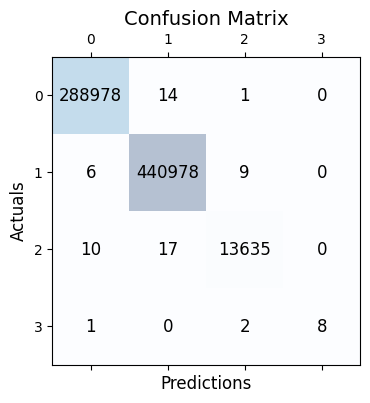

In [19]:
conf_matrix = confusion_matrix(Y_test, Y_pred)

fig, ax = plt.subplots(figsize = (4, 4))
ax.matshow(conf_matrix, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x = j, y = i,s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'large')
 
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.savefig("Results/Confusion Matrix/Botiot KNN")
plt.show()